### Get packages to train the model

In [1]:
import os
import cv2
import numpy as np
import random

from tensorflow import keras
from matplotlib import pyplot as plt

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

2025-01-15 10:48:31.218371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 10:48:31.313407: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 10:48:31.319228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-pack

### First attempt to train a model based on images generated

In [2]:
#constants to resize image to
HEIGHT = 90
WIDTH = 160


YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35


#get a lsit of files
mypath = '/home/winter/carla-ros-bridge/src/ros-bridge/learning_carla/GPS_and_CV/_img'
images = [f.split('.png')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)
# get a list when both are available: image and steering

In [3]:
# read training data 
X = [] #images
X1 = [] # gen direction
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_COLOR)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    X.append(image / 255) # adding another dimension and normalising pixels to 0-1
    # gen direction values are taken from after 1st '_' in file name
    X1.append(int(example.split('_')[1]))
    # y labels are taken from after 2nd '_' in file name
    y = float(example.split('_')[2])
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    if y >35:
        y = 35
    elif y<-35:
        y = -35
    
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    Y.append(y)

In [4]:
#convert to numpy arrays
X = np.array(X)
X1 = np.array(X1)
Y = np.array(Y)

In [5]:
def create_model():
    # Image input
    image_input = Input(shape=(HEIGHT, WIDTH, 3))
    # Integer input
    integer_input = Input(shape=(1,))
    
    # Preprocess the image input
    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(image_input)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same')(processed_image)
    processed_image = MaxPooling2D(pool_size=(2, 2))(processed_image)

    processed_image = Flatten()(processed_image)
    
    # Concatenate image features with integer input
    concatenated_inputs = Concatenate()([processed_image, integer_input])
    
    # Dense layers for prediction
    x = Dense(64, activation='relu')(concatenated_inputs)
    output = Dense(1, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=[image_input, integer_input], outputs=output)
    
    return model

model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 90, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 45, 80, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 80, 64)   36928       ['max_pooling2d[0][0]']      

2025-01-15 10:54:26.383110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-15 10:54:26.383315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages/cv2/../../lib64:/home/winter/carla-ros-bridge/install/rviz_carla_plugin/lib:/home/winter/carla-ros-bridge/install/carla_waypoint_types/lib:/home/winter/carla-ros-bridge/install/carla_ros_scenario_runner_types/lib:/home/winter/carla-ros-bridge/install/carla_ackermann_msgs/lib:/home/winter/carla-ros-bridge/install/carla_msgs/lib:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ro

In [7]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit([X, X1], Y, batch_size=16, shuffle=False, epochs=30, validation_split=0.2)

predictions = model.predict([X,X1])
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Epoch 1/30
57/57 [==============================] - 6s 80ms/step - loss: 0.1831 - MSE: 0.1831 - val_loss: 0.0671 - val_MSE: 0.0671
Epoch 2/30
57/57 [==============================] - 4s 77ms/step - loss: 0.0660 - MSE: 0.0660 - val_loss: 0.0473 - val_MSE: 0.0473
Epoch 3/30
57/57 [==============================] - 4s 77ms/step - loss: 0.0328 - MSE: 0.0328 - val_loss: 0.0232 - val_MSE: 0.0232
Epoch 4/30
57/57 [==============================] - 5s 79ms/step - loss: 0.0198 - MSE: 0.0198 - val_loss: 0.0233 - val_MSE: 0.0233
Epoch 5/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0128 - MSE: 0.0128 - val_loss: 0.0182 - val_MSE: 0.0182
Epoch 6/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0104 - MSE: 0.0104 - val_loss: 0.0162 - val_MSE: 0.0162
Epoch 7/30
57/57 [==============================] - 5s 79ms/step - loss: 0.0110 - MSE: 0.0110 - val_loss: 0.0197 - val_MSE: 0.0197
Epoch 8/30
57/57 [==============================] - 5s 80ms/step - loss: 0.0116 - M

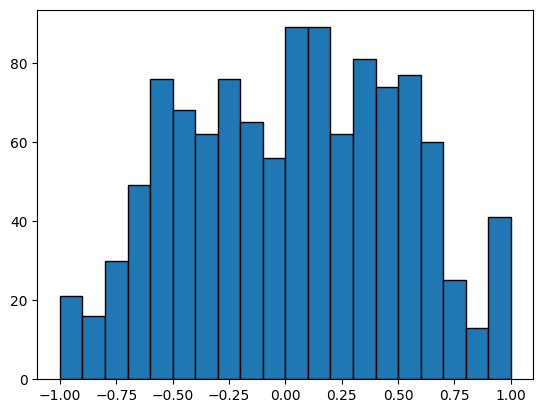

In [8]:
# Let's check distribution of our labels 
from matplotlib import pyplot as plt

frq, edges = np.histogram(Y, bins=20)
fig, ax = plt.subplots()
ax.bar(edges[:-1], frq, width=np.diff(edges), edgecolor="black", align="edge")

plt.show()

quite well distributed!

Let's save the model and test it

In [9]:
# to save model
model.save("GPS_Visual_Model_overfit", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit/assets


INFO:tensorflow:Assets written to: GPS_Visual_Model_overfit/assets
